In [11]:
import pandas as pd
import numpy as np
import keras as kr
import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

### Load data

In [2]:
#recipes
cleaned_recipes = json.load(open("./../generated/high_score_repr_recipes.json"))

#mapping
ing_mapping = json.load(open("./../generated/ing_usda_mapping_high_score.json"))

#group description
columns = ["food_group_id", "food_group_name"]
food_groups = pd.read_csv("./../data/usda/FD_GROUP.txt", sep="^", encoding="ISO-8859-1", names=columns, header=None)

#id mapping
columns = ["food_id", "food_group_id"]
use_cols = [0, 1]
food_des = pd.read_csv("./../data/usda/FOOD_DES.txt", sep="^", encoding="ISO-8859-1", names=columns, usecols=use_cols, header=None)

### Create food groups dictionnaries

In [3]:
#useful ids
usda_ids = [ing_mapping[ing]for ing in ing_mapping]

#matching ids dict
ids_dict = dict()
for usda_id in usda_ids :
    matching_group = int(food_des[food_des["food_id"] == usda_id]['food_group_id'].values[0])
    ids_dict[usda_id] = matching_group
    
json.dump(ids_dict, open("./../generated/food_to_group_high_score.json", 'w'))

#food groups description ids
group_des = dict()
for entry in food_groups.values :
    group_des[entry[0]] = entry[1]

json.dump(group_des, open("./../generated/group_des.json", 'w'))

### generate recipe's food groups vectors

In [4]:

food_groups_index = sorted(food_groups['food_group_id'])
food_groups_names = [group_des[fg_id] for fg_id in food_groups_index]

def recipe_to_ids(recipe) : return [int(ing[8:]) for ing in recipe if ing[:8] == 'usda_id=']
          
def ids_to_food_groups(ids) : return [ids_dict[i] for i in ids]

def food_groups_to_vector(food_groups) :
    count_vector = [0]*len(food_groups_index)
    for fg_id in food_groups :
        count_vector[food_groups_index.index(fg_id)] += 1
        
    return count_vector

def recipe_to_vector(recipe) : return food_groups_to_vector(ids_to_food_groups(recipe_to_ids(recipe)))    


#generate all vectors
vectors_recipes = []
for r in tqdm.tqdm(cleaned_recipes) :
    vector = recipe_to_vector(r)
    if sum(vector) != 0 :
        vectors_recipes.append(vector)
    
#translate to np array now that the append phase is over
vectors_recipes = np.array(vectors_recipes)    

100%|██████████| 96529/96529 [00:00<00:00, 123741.37it/s]


## vectors study

#### basic statistics

First, what are the numbers of ingredients in the recipes ?

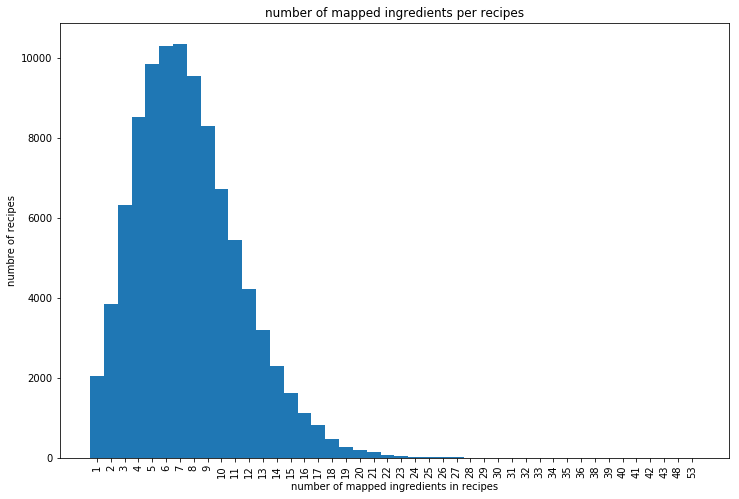

In [5]:
t = collections.Counter()
t.update([sum(vec) for vec in vectors_recipes])
t.most_common()

labels, values = zip(*sorted(t.items()))

indexes = np.arange(len(labels))
width = 1

plt.rcParams["figure.figsize"] = [12, 8]
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=90)
plt.title("number of mapped ingredients per recipes")
plt.xlabel("number of mapped ingredients in recipes")
plt.ylabel("numbre of recipes")
plt.show()

> we see that the main number of ingredients per recipes is 6 or 7. What types of ingredients are they (i.e., of which food group) ?

In [6]:
sorted([c for c in zip(vectors_recipes.sum(axis=0), food_groups_names)], key= lambda x : x[0])

[(547, 'Breakfast Cereals'),
 (1064, 'Restaurant Foods'),
 (1111, 'Baby Foods'),
 (1334, 'Lamb, Veal, and Game Products'),
 (1621, 'Meals, Entrees, and Side Dishes'),
 (1781, 'Fast Foods'),
 (2851, 'American Indian/Alaska Native Foods'),
 (3045, 'Finfish and Shellfish Products'),
 (3753, 'Poultry Products'),
 (3753, 'Beef Products'),
 (4067, 'Pork Products'),
 (6859, 'Snacks'),
 (10657, 'Nut and Seed Products'),
 (11018, 'Sausages and Luncheon Meats'),
 (23411, 'Legumes and Legume Products'),
 (25105, 'Soups, Sauces, and Gravies'),
 (29199, 'Beverages'),
 (31180, 'Cereal Grains and Pasta'),
 (31381, 'Baked Products'),
 (36060, 'Sweets'),
 (37571, 'Fruits and Fruit Juices'),
 (53487, 'Fats and Oils'),
 (99070, 'Dairy and Egg Products'),
 (145332, 'Spices and Herbs'),
 (169324, 'Vegetables and Vegetable Products')]

> As expected, the spices and the vegetables are the most common ingredients used. We notice that the snacks have been used a lot which is rather surprising.

Now, what is the mean recipe composition ?

In [7]:
mean_ings = sorted([c for c in zip(vectors_recipes.mean(axis=0), food_groups_names)], key= lambda x : x[0])
print("mean number of ingredients : ", sum([c[0] for c in mean_ings]))
mean_ings

mean number of ingredients :  7.646548762842599


[(0.005693942769109059, 'Breakfast Cereals'),
 (0.011075603485067713, 'Restaurant Foods'),
 (0.011564845368336681, 'Baby Foods'),
 (0.013886141963421363, 'Lamb, Veal, and Game Products'),
 (0.016873640271893576, 'Meals, Entrees, and Side Dishes'),
 (0.018539144555362402, 'Fast Foods'),
 (0.0296772044510602, 'American Indian/Alaska Native Foods'),
 (0.031696628394766155, 'Finfish and Shellfish Products'),
 (0.03906648484911572, 'Poultry Products'),
 (0.03906648484911572, 'Beef Products'),
 (0.0423350370054233, 'Pork Products'),
 (0.07139808675195436, 'Snacks'),
 (0.11093299468079569, 'Nut and Seed Products'),
 (0.11469078872037224, 'Sausages and Luncheon Meats'),
 (0.24369450487680472, 'Legumes and Legume Products'),
 (0.26132803147803096, 'Soups, Sauces, and Gravies'),
 (0.30394412233128965, 'Beverages'),
 (0.32456514724098806, 'Cereal Grains and Pasta'),
 (0.32665743699709576, 'Baked Products'),
 (0.3753630278867873, 'Sweets'),
 (0.3910916339637961, 'Fruits and Fruit Juices'),
 (0.556

We find again the mean number of ingredients. Let's standardize it to get the probability of each ingredient (by log likelihood, independence assumption)

In [8]:
sorted([c for c in zip(vectors_recipes.mean(axis=0) / sum(vectors_recipes.mean(axis=0)), food_groups_names)], key = lambda x : x[0])

[(0.0007446421837755129, 'Breakfast Cereals'),
 (0.0014484447596657146, 'Restaurant Foods'),
 (0.0015124268120193692, 'Baby Foods'),
 (0.001816001230633518, 'Lamb, Veal, and Game Products'),
 (0.002206700146069665, 'Meals, Entrees, and Side Dishes'),
 (0.002424511388124659, 'Fast Foods'),
 (0.003881124069367436, 'American Indian/Alaska Native Foods'),
 (0.004145220200359117, 'Finfish and Shellfish Products'),
 (0.005109034946452469, 'Poultry Products'),
 (0.005109034946452469, 'Beef Products'),
 (0.005536489508985396, 'Pork Products'),
 (0.009337295682845052, 'Snacks'),
 (0.014507590041125487, 'Nut and Seed Products'),
 (0.014999026656012068, 'Sausages and Luncheon Meats'),
 (0.03186986867343425, 'Legumes and Legume Products'),
 (0.03417594519869151, 'Soups, Sauces, and Gravies'),
 (0.039749190354773686, 'Beverages'),
 (0.04244596579546708, 'Cereal Grains and Pasta'),
 (0.04271959116829867, 'Baked Products'),
 (0.04908920867814442, 'Sweets'),
 (0.051146163595301275, 'Fruits and Fruit J

Those results are interesting but we agglomerate all the recipes together and lose the ability to distinguish some recipes categories. We now try to discover hidden recipe compositions patterns by clustering the recipes.

### Food group prediction by deep learning

> We decide to ignore the recipes with less than 4 ingredients (probably badly parsed) and those with more than 15 ingredients (not representative enough). We build a neural network and train it to predict which food group should be added to a recipe

In [13]:
list(zip(vectors_recipes[0], food_groups_names))

[(1, 'Dairy and Egg Products'),
 (1, 'Spices and Herbs'),
 (0, 'Baby Foods'),
 (0, 'Fats and Oils'),
 (0, 'Poultry Products'),
 (0, 'Soups, Sauces, and Gravies'),
 (0, 'Sausages and Luncheon Meats'),
 (0, 'Breakfast Cereals'),
 (0, 'Fruits and Fruit Juices'),
 (0, 'Pork Products'),
 (3, 'Vegetables and Vegetable Products'),
 (0, 'Nut and Seed Products'),
 (0, 'Beef Products'),
 (0, 'Beverages'),
 (0, 'Finfish and Shellfish Products'),
 (1, 'Legumes and Legume Products'),
 (0, 'Lamb, Veal, and Game Products'),
 (0, 'Baked Products'),
 (0, 'Sweets'),
 (0, 'Cereal Grains and Pasta'),
 (0, 'Fast Foods'),
 (0, 'Meals, Entrees, and Side Dishes'),
 (0, 'Snacks'),
 (0, 'American Indian/Alaska Native Foods'),
 (0, 'Restaurant Foods')]

In [50]:
#neural network with two dense layers 
model = Sequential()
model.add(Dense(25))
model.add(Activation('relu'))
model.add(Dense(25))
model.add(Activation('relu'))
model.add(Dense(25))
model.add(Activation('relu'))



#filter recipes by number of ingredients
filtered_recipes = [v for v in vectors_recipes if ((sum(v) <= 12) and (sum(v) >= 4))]

X = []
Y = []

for f in tqdm.tqdm_notebook(filtered_recipes) :
    for e, food_group in enumerate(f) :
        
        if food_group != 0 :
            new_recipe = f.copy()
            new_recipe[e] -= 1
            X.append(new_recipe)
            y = np.zeros(len(f))
            y[e] = 1
            Y.append(y)
            


In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.array(X), np.array(Y), batch_size = 128, epochs = 40, verbose = 1, validation_split = 0.2, shuffle = True)

Train on 283750 samples, validate on 70938 samples
Epoch 1/40
283750/283750 [==============================] - 3s 11us/step - loss: 3.0795 - acc: 0.2585 - val_loss: 2.8742 - val_acc: 0.2575
Epoch 2/40
283750/283750 [==============================] - 3s 9us/step - loss: 3.0787 - acc: 0.2590 - val_loss: 2.8705 - val_acc: 0.2564
Epoch 3/40
283750/283750 [==============================] - 2s 9us/step - loss: 3.0788 - acc: 0.2585 - val_loss: 2.8652 - val_acc: 0.2583
Epoch 4/40
283750/283750 [==============================] - 2s 9us/step - loss: 3.0786 - acc: 0.2583 - val_loss: 2.8665 - val_acc: 0.2569
Epoch 5/40
283750/283750 [==============================] - 2s 9us/step - loss: 3.0806 - acc: 0.2585 - val_loss: 2.8724 - val_acc: 0.2577
Epoch 6/40
283750/283750 [==============================] - 3s 9us/step - loss: 3.0773 - acc: 0.2588 - val_loss: 2.8635 - val_acc: 0.2569
Epoch 7/40
283750/283750 [==============================] - 2s 9us/step - loss: 3.0769 - acc: 0.2587 - val_loss: 2.8655 